In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
import time
import pickle
# set image size to default
plt.rcParams['figure.figsize']=(19,5)

import patsy
%matplotlib inline
plt.style.use('seaborn')

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, fbeta_score, make_scorer, roc_auc_score, roc_curve, classification_report
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [3]:
with open ('TimeSeries.pkl', 'rb') as file:
    df_weather = pickle.load(file)

In [4]:
# Scale data
ssX = StandardScaler()
exclude = ['Trip Total','Trip Seconds', '-L']
X = df_weather[[x for x in df_weather.columns if x not in exclude]]
y1 = df_weather['-L']
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.2, random_state=42)

X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

In [5]:
def train_scores(lr):
    kfold = KFold(n_splits=5)
    results = {
        'train': [],
        'validation': []
    }
    for train_indicies, test_indicies in kfold.split(X_train_scaled):
        lr.fit(X_train_scaled[train_indicies], y1_train.values[train_indicies])
        predictions = lr.predict(X_train_scaled[train_indicies])
        train_score = np.mean(-abs(predictions - y1_train.values[train_indicies]))
        
        predictions = lr.predict(X_train_scaled[test_indicies])
        val_score = np.mean(-abs(predictions - y1_train.values[test_indicies]))
        
        results['train'].append(train_score)
        results['validation'].append(val_score)
        
    return results

## Build a Linear model on demand

In [13]:
model1 = LinearRegression()
model1.fit(X_train_scaled, y1_train)
y1_predict = model1.predict(X_test_scaled)
print('RMSE for model is ' + str(np.sqrt(mean_squared_error(y1_test, y1_predict))))

RMSE for model is 5.038365674460532


In [12]:
dummy = DummyRegressor()
dummy.fit(X_train_scaled, y1_train)
yd_predict = dummy.predict(X_test_scaled)
print('RMSE for dummy is ' + str(np.sqrt(mean_squared_error(y1_test, yd_predict))))

RMSE for dummy is 14.90287842719264


## GridSearch on Linear Regression - Lasso

In [16]:
%%time
model1 = Lasso(max_iter=5000)
parameters = {'alpha': [1e-10, 1e-7, 1e-5,1e-3], 'fit_intercept': [True,False]}
grid1 = GridSearchCV(model1,parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid1.fit(X_train, y1_train)

CPU times: user 55.7 s, sys: 814 ms, total: 56.5 s
Wall time: 57 s


In [18]:
grid1.cv_results_

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([1.27716079, 3.0306715 , 1.00108314, 2.02410798, 0.74895754,
        1.52068262, 0.4826088 , 1.00250583]),
 'mean_score_time': array([0.0038403 , 0.00313816, 0.00262861, 0.00245938, 0.00250521,
        0.00253339, 0.00268359, 0.0025784 ]),
 'mean_test_score': array([-25.1573212 , -25.25567401, -25.15732116, -25.255674  ,
        -25.15731684, -25.25567258, -25.15745118, -25.25537721]),
 'mean_train_score': array([-25.14242325, -25.24092772, -25.14242325, -25.24092772,
        -25.1424233 , -25.24092776, -25.14265608, -25.24109117]),
 'param_alpha': masked_array(data=[1e-10, 1e-10, 1e-07, 1e-07, 1e-05, 1e-05, 0.001, 0.001],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, False, True, False, True, False, True, False],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=

In [19]:
best_lasso = grid1.best_estimator_
lasso_pred = best_lasso.predict(X_test)
np.sqrt(mean_squared_error(y1_test, lasso_pred))

5.038365786271146

## GridSearch on Linear Regression - Ridge

In [20]:
model2 = Ridge(max_iter=5000)
parameters = {'alpha': [1,2,3,4,5], 'fit_intercept': [True,False]}
grid2 = GridSearchCV(model2,parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid2.fit(X_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 2, 3, 4, 5], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
grid2.cv_results_

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([0.03586049, 0.02565622, 0.02569513, 0.02474899, 0.03220153,
        0.02436008, 0.02625413, 0.02530699, 0.02841249, 0.02564354]),
 'mean_score_time': array([0.00290604, 0.00386195, 0.00252213, 0.00240397, 0.00268173,
        0.00246539, 0.00238147, 0.00525599, 0.00289826, 0.00251155]),
 'mean_test_score': array([-25.15732039, -25.25567335, -25.15731957, -25.25567269,
        -25.15731877, -25.25567204, -25.15731797, -25.25567139,
        -25.15731718, -25.25567074]),
 'mean_train_score': array([-25.14242325, -25.24092772, -25.14242326, -25.24092772,
        -25.14242326, -25.24092772, -25.14242327, -25.24092773,
        -25.14242329, -25.24092774]),
 'param_alpha': masked_array(data=[1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, False, True, False, True, False, True, 

In [22]:
best_ridge = grid2.best_estimator_
ridge_pred = best_ridge.predict(X_test)
print(np.sqrt(mean_squared_error(y1_test, ridge_pred)))

5.038365495247363


## Random Forest Classifer

In [23]:
rf = RandomForestRegressor()
parameters = {'max_depth': [9,10,11], 'max_features':[9,10,11,12]}
grid3 = GridSearchCV(rf,parameters, cv=5, n_jobs=-1)
grid3.fit(X_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [9, 10, 11], 'max_features': [9, 10, 11, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
grid3.cv_results_

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([1.70818467, 1.79513617, 1.96659918, 2.12555695, 1.80241995,
        2.01333227, 2.25068178, 2.49709725, 2.15018506, 2.37582932,
        2.46724057, 2.48473792]),
 'mean_score_time': array([0.03183494, 0.03056087, 0.02875376, 0.03082466, 0.03322244,
        0.03357468, 0.0343492 , 0.03544717, 0.04126959, 0.03844953,
        0.0403666 , 0.03204713]),
 'mean_test_score': array([0.88396744, 0.88396494, 0.88394518, 0.88380212, 0.88391424,
        0.88382827, 0.88381401, 0.88369343, 0.88369897, 0.88324385,
        0.88329601, 0.88351271]),
 'mean_train_score': array([0.89495125, 0.89538698, 0.89551154, 0.89562207, 0.90117052,
        0.90134283, 0.90167812, 0.90161387, 0.90823303, 0.90848168,
        0.90882339, 0.9088941 ]),
 'param_max_depth': masked_array(data=[9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
            

In [30]:
# find the best estimator in RF Regressor Grid Search
rfm = grid3.best_estimator_
y1_predict_rfm = rfm.predict(X_test)
print('RMSE for model is ' + str(np.sqrt(mean_squared_error(y1_test, y1_predict_rfm))))

RMSE for model is 5.107723010362706


In [34]:
sorted_importance_indicies = np.argsort(abs(rfm.feature_importances_))
rfm.feature_importances_.reshape(-1)[sorted_importance_indicies.reshape(-1)]
sorted_importance_indicies.reshape(-1)[-5:]

array([16, 17, 15, 14,  0])

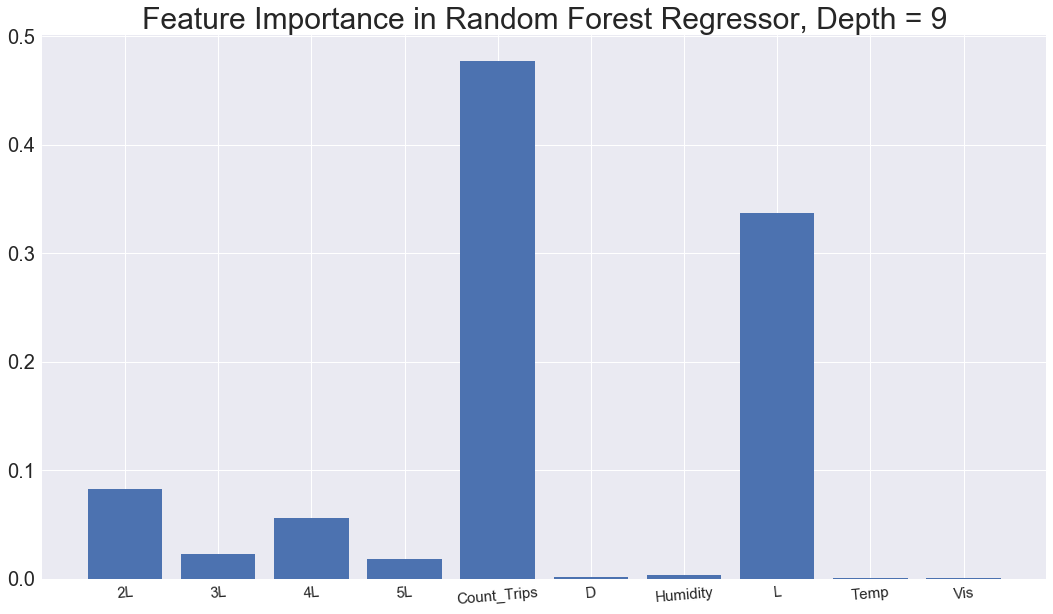

In [36]:
plt.figure(figsize=(18,10))
plt.title("Feature Importance in Random Forest Regressor, Depth = 9",fontsize=30)
coefs_size = abs(rfm.feature_importances_.reshape(-1))
labels = X_train.columns[sorted_importance_indicies.reshape(-1)[-10:]]
plt.bar(labels, coefs_size[sorted_importance_indicies.reshape(-1)[-10:]])
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.xticks(rotation=5);

## Linear SVM

In [37]:
svc = LinearSVC()

In [ ]:
params  = [{'C':[1, 3, 5, 7, 9]}]
svm1 = GridSearchCV(svc, params, cv=5, scoring = "neg_mean_squared_error")
svm1.fit(X_train_scaled, y1_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
